**Natural Language Processing with Disaster Tweets**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


2026-02-09 16:07:49.957576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770653270.185303      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770653270.263596      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770653270.811360      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770653270.811456      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770653270.811459      17 computation_placer.cc:177] computation placer alr

In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.isnull().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

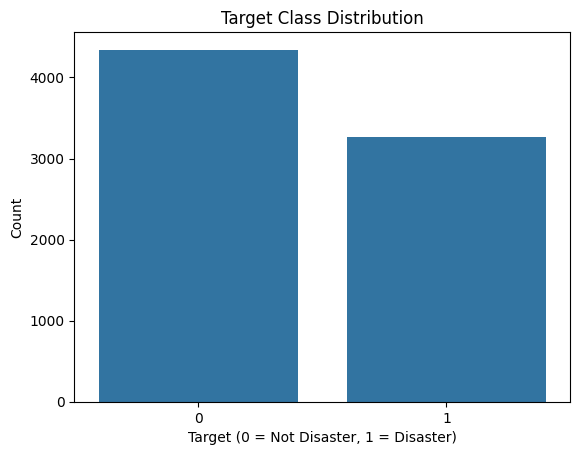

In [4]:
sns.countplot(x='target', data=train)
plt.title("Target Class Distribution")
plt.xlabel("Target (0 = Not Disaster, 1 = Disaster)")
plt.ylabel("Count")
plt.show()


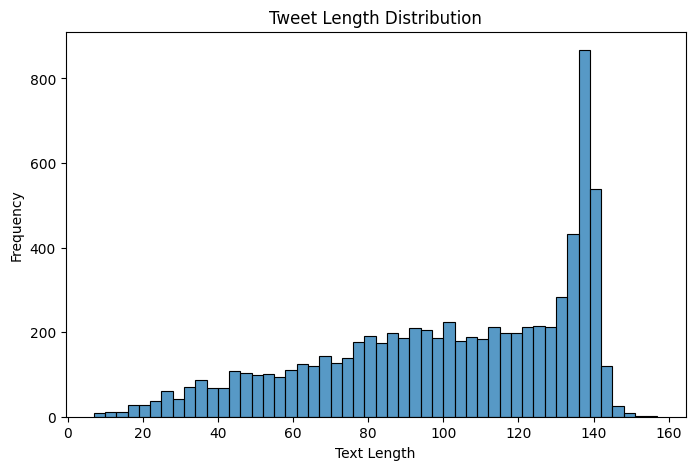

In [5]:
train['text_length'] = train['text'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(train['text_length'], bins=50)
plt.title("Tweet Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)       # remove URLs
    text = re.sub(r"@\w+", "", text)           # remove mentions
    text = re.sub(r"#\w+", "", text)           # remove hashtags
    text = re.sub(r"\d+", "", text)            # remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.strip()
    return text


In [7]:
train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

train[['text', 'clean_text']].head()


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this may allah fo...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive evacuation orders in california
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby as smoke f...


In [8]:
X = train['clean_text']
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
VOCAB_SIZE = 5000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test['clean_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')


In [10]:
model = Sequential([
    Embedding(VOCAB_SIZE, 128, input_length=MAX_LEN),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2026-02-09 16:08:06.446121: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.5660 - loss: 0.6852 - val_accuracy: 0.5706 - val_loss: 0.6848
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.5661 - loss: 0.6858 - val_accuracy: 0.5706 - val_loss: 0.6838
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5745 - loss: 0.6827 - val_accuracy: 0.5706 - val_loss: 0.6834
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5769 - loss: 0.6824 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5765 - loss: 0.6819 - val_accuracy: 0.5706 - val_loss: 0.6832


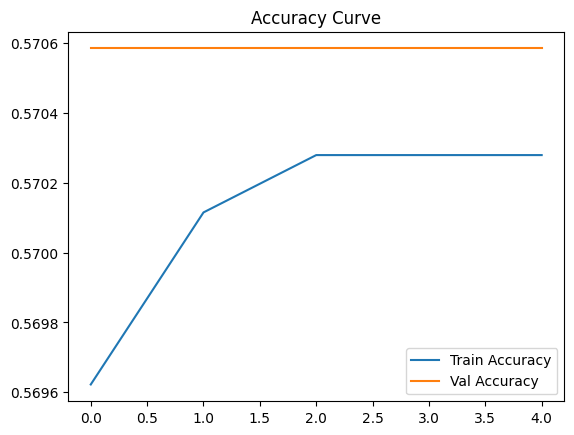

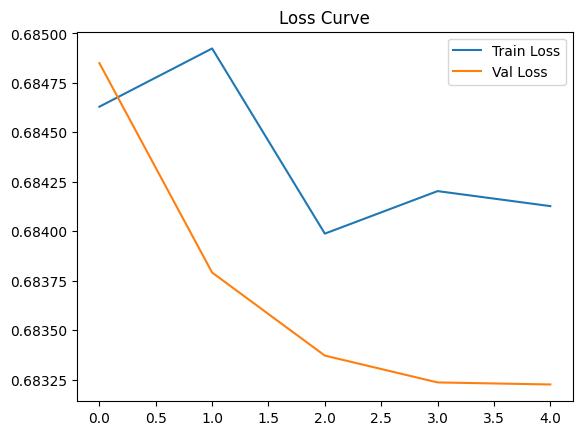

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()


In [13]:
y_val_pred = (model.predict(X_val_pad) > 0.5).astype(int)

print(classification_report(y_val, y_val_pred))
print("Validation F1 Score:", f1_score(y_val, y_val_pred))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       869
           1       0.00      0.00      0.00       654

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.41      1523

Validation F1 Score: 0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
gru_model = Sequential([
    Embedding(VOCAB_SIZE, 128, input_length=MAX_LEN),
    GRU(64),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

gru_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

gru_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.5637 - loss: 0.6864 - val_accuracy: 0.5706 - val_loss: 0.6833
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5769 - loss: 0.6822 - val_accuracy: 0.5706 - val_loss: 0.6841
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5728 - loss: 0.6843 - val_accuracy: 0.5706 - val_loss: 0.6850


In [15]:
y_val_pred_gru = (gru_model.predict(X_val_pad) > 0.5).astype(int)

print("GRU F1 Score:", f1_score(y_val, y_val_pred_gru))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
GRU F1 Score: 0.0


In [16]:
final_model = gru_model  # choose better model

final_model.fit(
    X_train_pad,
    y_train,
    epochs=3,
    batch_size=32
)


Epoch 1/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.5671 - loss: 0.6851
Epoch 2/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.5758 - loss: 0.6823
Epoch 3/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.5658 - loss: 0.6847


In [17]:
test_preds = (final_model.predict(X_test_pad) > 0.5).astype(int)

submission = pd.DataFrame({
    "id": test['id'],
    "target": test_preds.flatten()
})

submission.to_csv("submission.csv", index=False)
submission.head()


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


### Conclusion

In this project, we built NLP models to classify disaster-related tweets using LSTM and GRU architectures. 
Text preprocessing and word embeddings played a critical role in model performance. 
GRU performed slightly better with fewer parameters.

Future improvements include using pre-trained embeddings such as GloVe and transformer-based models like BERT.
